In [1]:
import sys
import os
import torch
import pyspark 
import copy
import math
import rawpy
import random
import matplotlib
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from torch import nn
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2DTranspose, UpSampling2D, Conv2D
from tensorflow.keras.layers import LSTM,Embedding,Dropout,Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import lib
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

torch.manual_seed(11)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# ./Training  2_class_fire_or_no_fire_winter

### https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs

In [33]:

train_path = "./Training"
train_path_fire = train_path+ "/Fire"
train_path_no_fire = train_path+ "/No_Fire"


dataset = "./Training"
output_pdf = True
output_statistics = False
image_size = 224
model_name = 'mobilenet_v2'
hidden_layers = [128, 64, 32]
num_classes = 2
batch_size = 16
epochs = 10



In [34]:
METRICS = ['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

baseModel = tf.keras.applications.MobileNetV2(
    alpha=1.0,
    input_shape= (224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

# baseModel = tf.keras.applications.EfficientNetB7(
#     include_top=False,
#     input_shape= (224, 224, 3),
#     weights="imagenet",
#     pooling='avg',
# )


baseModel = tf.keras.Model(baseModel.input, baseModel.get_layer(name = "out_relu").output )
# baseModel = tf.keras.Model(baseModel.input, baseModel.get_layer(name = "top_conv").output )
model = Sequential()

# Transfer Learning
model.add(baseModel)
model.layers[0].trainable = True  
model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))   
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))

model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.add(Flatten())
#model.add(tf.keras.layers.Dropout(0.2))
for layer in range(len(hidden_layers)):
    model.add(Dense(hidden_layers[layer], activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))

# Add our classification layer and display model properties
model.add(Dense(num_classes, activation='softmax'))
model.summary()

#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# Compile the sections into one NN
model.compile(optimizer='sgd', loss='binary_crossentropy',
              metrics=METRICS)



# opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# # Compile the sections into one NN
# model.compile(optimizer=opt, loss='binary_crossentropy',
#               metrics=METRICS)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 7, 7, 1280)        2257984   
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 9, 9, 16)         184336    
 Transpose)                                                      
                                                                 
 conv2d_transpose_37 (Conv2D  (None, 11, 11, 32)       4640      
 Transpose)                                                      
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_38 (Conv2D  (None, 24, 24, 32)       9248      
 Transpose)                                           

In [ ]:
# train the model
data_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                    brightness_range=[0.2,1.0],
                                    rotation_range=90,
                                    horizontal_flip=True,
                                    width_shift_range=[-30,30])
                                    #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = data_generator.flow_from_directory(
    f'{dataset}',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
num_training_files = len(train_generator.filepaths)

validation_generator = data_generator.flow_from_directory(
                f'./Test',
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.1,   patience=2,  min_lr=1e-5) 

# The division by 5 here is to make training quicker
# when you want maximum accuracy remove it.
history =  model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[lrr,es_callback])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'{model_name}_2_fire_or_no_fire_winter accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{model_name}_2_fire_or_no_fire_winter loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.
Epoch 1/10
 545/2461 [=====>........................] - ETA: 6:31 - loss: 0.2524 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926

In [6]:
data_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                    brightness_range=[0.2,1.0],
                                    rotation_range=90,
                                    horizontal_flip=True,
                                    width_shift_range=[-30,30],
        #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

print("Test" + model_name)
test_generator = data_generator.flow_from_directory(
                f'./Test',
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=False)
num_files = len(test_generator.filepaths)

steps = num_files/batch_size

model.evaluate(test_generator, steps=steps)


Testmobilenet_v2
Found 8617 images belonging to 2 classes.
538/538 [==============================] - 106s 196ms/step - loss: 1.1245 - accuracy: 0.6263 - precision: 0.6263 - recall: 0.6263


[1.1245496273040771,
 0.6263200640678406,
 0.6263200640678406,
 0.6263200640678406]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 8617 images belonging to 2 classes.


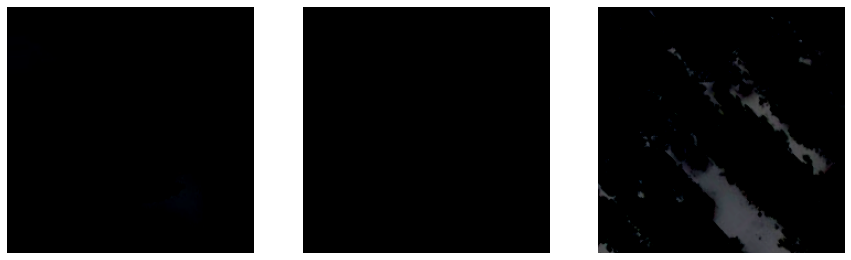

In [20]:
# ImageDataGenerator shifting
data_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                    brightness_range=[0.2,1.0],
                                    rotation_range=90,
                                    horizontal_flip=True,
                                    width_shift_range=[-30,30],
                                   #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
        #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_generator = data_generator.flow_from_directory(
                f'./Test',
                target_size=(image_size, image_size),
                batch_size=1,
                class_mode='categorical',
                shuffle=True)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(test_generator)[0]
 
	# plot image
	ax[i].imshow(image[0])
	ax[i].axis('off')

In [27]:
model.save(f'./3_models_series/mobilenet_v2/2_fire_or_no_fire_winter.h5')


# ./FIRE-SMOKE-DATASET/FIRE-SMOKE-DATASET/Train 3_classes_fire_neutral_smoke

### https://github.com/DeepQuestAI/Fire-Smoke-Dataset

In [28]:

dataset = "./FIRE-SMOKE-DATASET/FIRE-SMOKE-DATASET/Train"
output_pdf = True
output_statistics = False
image_size = 224
model_name = 'mobilenet_v2'
hidden_layers = [128, 64, 32]
num_classes = 3
batch_size = 64
epochs = 100


In [16]:
METRICS = ['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

# baseModel = EfficientNetB7(
#     include_top=False, pooling='avg', weights='imagenet')

baseModel = tf.keras.applications.MobileNetV2(
    alpha=1.0,
    input_shape= (224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)


baseModel = tf.keras.Model(baseModel.input, baseModel.get_layer(name = "out_relu").output )

model = Sequential()

# Transfer Learning
model.add(baseModel)
model.layers[0].trainable = True  
model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))   
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))

model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.add(Flatten())

for layer in range(len(hidden_layers)):
    model.add(Dense(hidden_layers[layer], activation='relu'))

# Add our classification layer and display model properties
model.add(Dense(num_classes, activation='softmax'))
model.summary()

#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# Compile the sections into one NN
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=METRICS)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 7, 7, 1280)        2257984   
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 9, 9, 16)         184336    
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 11, 11, 32)       4640      
 Transpose)                                                      
                                                                 
 up_sampling2d_8 (UpSampling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 24, 24, 32)       9248      
 Transpose)                                           

Found 2700 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/100
43/43 [==============================] - 15s 254ms/step - loss: 1.0369 - accuracy: 0.4652 - precision: 0.6685 - recall: 0.0441 - val_loss: 0.9319 - val_accuracy: 0.6133 - val_precision: 0.8600 - val_recall: 0.1433 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - 9s 216ms/step - loss: 0.8443 - accuracy: 0.6215 - precision: 0.7293 - recall: 0.4170 - val_loss: 0.7481 - val_accuracy: 0.7100 - val_precision: 0.8069 - val_recall: 0.5433 - lr: 0.0100
Epoch 3/100
43/43 [==============================] - 10s 222ms/step - loss: 0.6775 - accuracy: 0.7022 - precision: 0.7426 - recall: 0.6281 - val_loss: 0.6037 - val_accuracy: 0.7567 - val_precision: 0.7774 - val_recall: 0.7333 - lr: 0.0100
Epoch 4/100
43/43 [==============================] - 10s 230ms/step - loss: 0.5879 - accuracy: 0.7474 - precision: 0.7707 - recall: 0.7122 - val_loss: 0.5777 - val_accuracy: 0.7700 - val_precision: 0.7

Epoch 35/100
43/43 [==============================] - 10s 218ms/step - loss: 0.0110 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - val_loss: 0.3964 - val_accuracy: 0.9167 - val_precision: 0.9195 - val_recall: 0.9133 - lr: 0.0100
Epoch 36/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0100 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - val_loss: 0.4257 - val_accuracy: 0.9067 - val_precision: 0.9094 - val_recall: 0.9033 - lr: 0.0100
Epoch 37/100
43/43 [==============================] - 10s 220ms/step - loss: 0.0084 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - val_loss: 0.4133 - val_accuracy: 0.9133 - val_precision: 0.9130 - val_recall: 0.9100 - lr: 0.0100
Epoch 38/100
43/43 [==============================] - 10s 222ms/step - loss: 0.0070 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - val_loss: 0.4091 - val_accuracy: 0.9133 - val_precision: 0.9130 - val_recall: 0.9100 - lr: 1.0000e-03
dict_keys(['loss', 'accuracy', 'prec

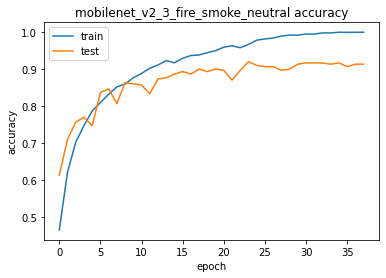

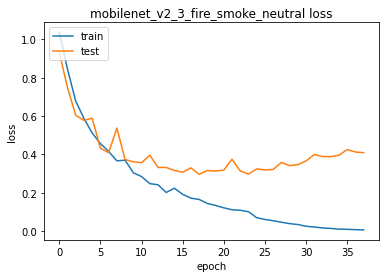

In [17]:
# train the model
data_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                    brightness_range=[0.2,1.0],
                                    rotation_range=90,
                                    horizontal_flip=True,
                                    width_shift_range=[-30,30])
        #preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = data_generator.flow_from_directory(
    f'{dataset}',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
                shuffle=True)
num_training_files = len(train_generator.filepaths)

validation_generator = data_generator.flow_from_directory(
                f'./FIRE-SMOKE-DATASET/FIRE-SMOKE-DATASET/Test',
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.5 ,   patience=4,  min_lr=1e-10) 

# The division by 5 here is to make training quicker
# when you want maximum accuracy remove it.
history =  model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[lrr,es_callback])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'{model_name}_3_fire_smoke_neutral accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{model_name}_3_fire_smoke_neutral loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
data_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

print("Test" + model_name)
test_generator = data_generator.flow_from_directory(
        f'FIRE-SMOKE-DATASET/FIRE-SMOKE-DATASET/Test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
num_files = len(test_generator.filepaths)

steps = num_files/batch_size

model.evaluate(test_generator, steps=steps)


Testmobilenet_v2
Found 300 images belonging to 3 classes.
4/4 [==============================] - 1s 166ms/step - loss: 0.4091 - accuracy: 0.9133 - precision: 0.9130 - recall: 0.9100


[0.40914374589920044,
 0.9133333563804626,
 0.9130434989929199,
 0.9100000262260437]

In [79]:
model.save(f'./3_models_series/mobilenet_v2/{model_name}_3_fire_smoke_neutral.h5')


# E:\Facultate\Siva_master\Projects\git\change_detection\fire_smoke\Dataset\Training and Validation  2_class_fire_or_no_fire

### https://data.mendeley.com/datasets/gjmr63rz2r/1

In [19]:
dataset = "./fire_smoke/Dataset/Training and Validation"
output_pdf = True
output_statistics = False
image_size = 224
model_name = 'mobilenet_v2'
hidden_layers = [128, 64, 32]
num_classes = 2
batch_size = 64
epochs = 100


In [20]:
METRICS = ['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

# baseModel = EfficientNetB7(
#     include_top=False, pooling='avg', weights='imagenet')

baseModel = tf.keras.applications.MobileNetV2(
    alpha=1.0,
    input_shape= (224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
baseModel = tf.keras.Model(baseModel.input, baseModel.get_layer(name = "out_relu").output )

model = Sequential()

# Transfer Learning
model.add(baseModel)
model.layers[0].trainable = False  
model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(UpSampling2D((2, 2)))   
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))

model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.add(Flatten())

for layer in range(len(hidden_layers)):
    model.add(Dense(hidden_layers[layer], activation='relu'))

# Add our classification layer and display model properties
model.add(Dense(num_classes, activation='softmax'))
model.summary()

#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# Compile the sections into one NN
model.compile(optimizer='sgd', loss='binary_crossentropy',
              metrics=METRICS)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 7, 7, 1280)        2257984   
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 9, 9, 16)         184336    
 Transpose)                                                      
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 11, 11, 32)       4640      
 Transpose)                                                      
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 24, 24, 32)       9248      
 Transpose)                                           

Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.
Epoch 1/100
24/24 [==============================] - 16s 522ms/step - loss: 0.6706 - accuracy: 0.6013 - precision: 0.6013 - recall: 0.6013 - val_loss: 0.6184 - val_accuracy: 0.8158 - val_precision: 0.8158 - val_recall: 0.8158 - lr: 0.0100
Epoch 2/100
24/24 [==============================] - 6s 238ms/step - loss: 0.5180 - accuracy: 0.8243 - precision: 0.8243 - recall: 0.8243 - val_loss: 0.4256 - val_accuracy: 0.8474 - val_precision: 0.8474 - val_recall: 0.8474 - lr: 0.0100
Epoch 3/100
24/24 [==============================] - 6s 236ms/step - loss: 0.3175 - accuracy: 0.9066 - precision: 0.9066 - recall: 0.9066 - val_loss: 0.3978 - val_accuracy: 0.8342 - val_precision: 0.8342 - val_recall: 0.8342 - lr: 0.0100
Epoch 4/100
24/24 [==============================] - 6s 237ms/step - loss: 0.2097 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - val_loss: 0.2490 - val_accuracy: 0.9105 - val_precision: 0.910

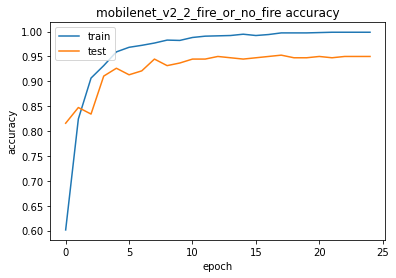

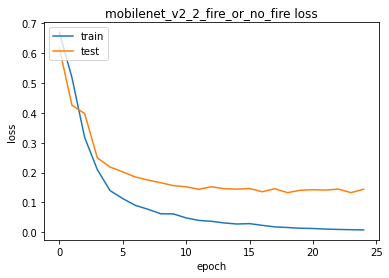

In [21]:
# train the model
data_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = data_generator.flow_from_directory(
    f'{dataset}',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')
num_training_files = len(train_generator.filepaths)

validation_generator = data_generator.flow_from_directory(
                f'./fire_smoke\Dataset\Testing',
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.5 ,   patience=4,  min_lr=1e-10) 

# The division by 5 here is to make training quicker
# when you want maximum accuracy remove it.
history =  model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[lrr,es_callback])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'{model_name}_2_fire_or_no_fire accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{model_name}_2_fire_or_no_fire loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
data_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

print("Test" + model_name)
test_generator = data_generator.flow_from_directory(
        f'fire_smoke/Dataset/Testing',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
num_files = len(test_generator.filepaths)

steps = num_files/batch_size

model.evaluate(test_generator, steps=steps)



Testmobilenet_v2
Found 380 images belonging to 2 classes.
5/5 [==============================] - 3s 208ms/step - loss: 0.1404 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684


[0.14035210013389587,
 0.9684210419654846,
 0.9684210419654846,
 0.9684210419654846]

In [84]:
model.save(f'./3_models_series/mobilenet_v2/{model_name}_2_fire_or_no_fire.h5')


# Inference

In [22]:
fire_detection_fire_no_fire_winter = tf.keras.models.load_model(f'./3_models_series/mobilenet_v2/{model_name}_2_fire_or_no_fire_winter.h5')
fire_detection_fire_neutral_smoke = tf.keras.models.load_model(f'./3_models_series/mobilenet_v2/{model_name}_3_fire_smoke_neutral.h5')
fire_detection_fire_no_fire = tf.keras.models.load_model(f'./3_models_series/mobilenet_v2/{model_name}_2_fire_or_no_fire.h5')


In [23]:
images_path = './fire_testing_images'

In [24]:
os.listdir(images_path)

['fire_1.jpg', 'fire_2.jpg', 'no_fire_1.jpg', 'smoke_1.jpeg']

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/abc212.jpg is: 0


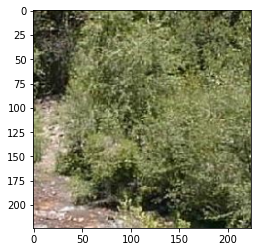

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


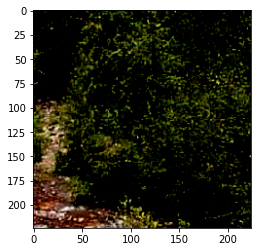

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/abc231.jpg is: 2


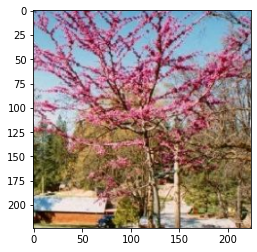

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


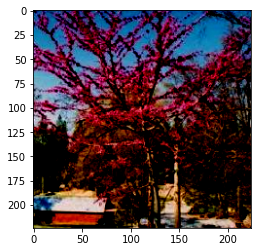

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/abc232.jpg is: 2


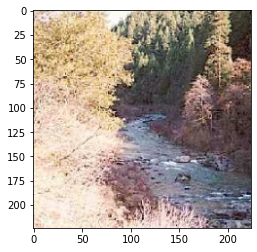

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


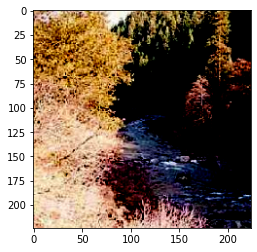

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/abc233.jpg is: 2


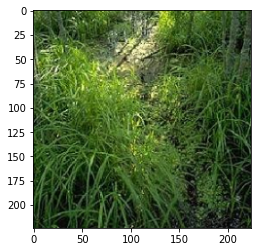

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


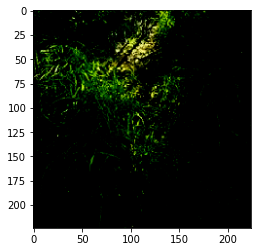

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/fire_0260.jpg is: 0


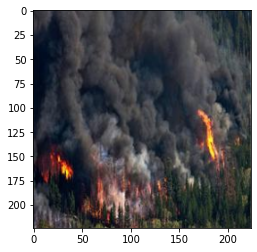

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


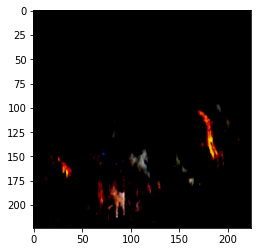

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/fire_0261.jpg is: 0


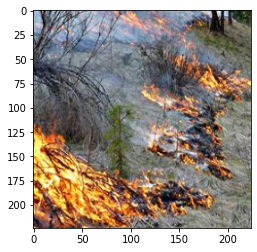

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


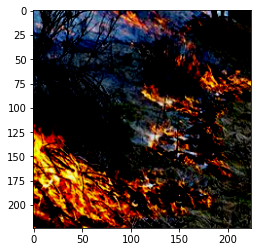

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/fire_0262.jpg is: 0


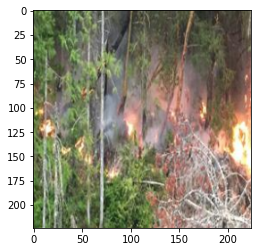

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


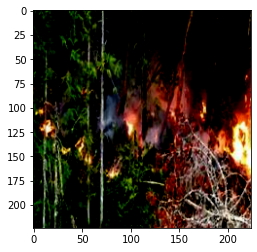

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/fire_1.jpg is: 2


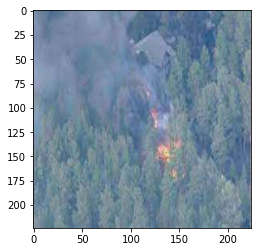

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


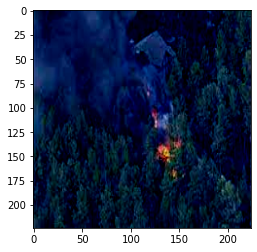

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/fire_2.jpg is: 2


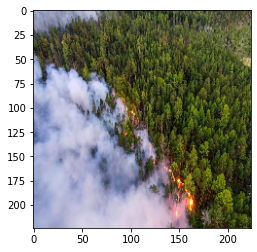

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


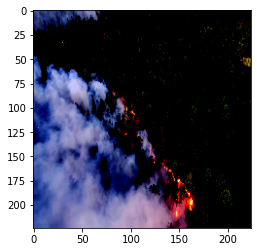

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/no_fire_1.jpg is: 1


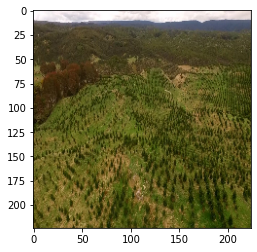

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


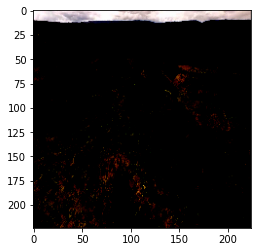

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/no_fire_2.jpg is: 1


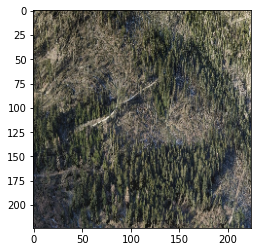

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


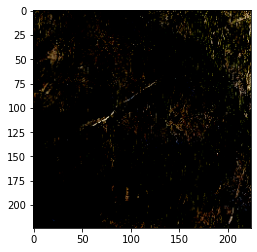

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/no_fire_3.jpg is: 1


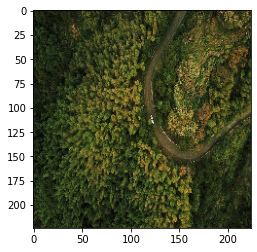

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


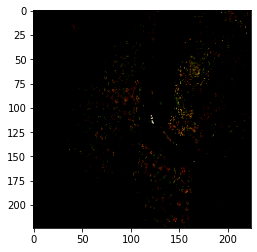

fire_detection_fire_no_fire_winter prediction for ./fire_testing_images/smoke_1.jpeg is: 2


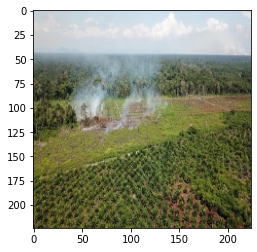

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


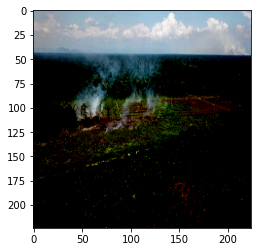

In [40]:
for image in os.listdir(images_path):
    path = images_path + "/" + image
    image =cv.imread(path)
    image =cv.cvtColor(image,cv.COLOR_BGR2RGB)
    image =cv.resize(image,(224,224))

    preproc_image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    preproc_image = np.expand_dims(preproc_image, axis=0)
    result = fire_detection_fire_neutral_smoke.predict(preproc_image)
    
    print(f"fire_detection_fire_no_fire_winter prediction for {path} is: {np.argmax(result)}")
    plt.imshow(image), plt.show()
    plt.imshow(preproc_image[0]), plt.show()
    